In [16]:
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
from IPython.display import clear_output
import time
from pathlib import Path
import copy
import matplotlib.pyplot as plt

import proper
proper.prop_use_fftw(DISABLE=True)

import roman_phasec_proper
roman_phasec_proper.copy_here()

import misc
from matplotlib.patches import Circle

data_dir = Path('/groups/douglase/kians-data-files/disk-processing')

wavelength_c = 575e-9*u.m
D = 2.3631*u.m
mas_per_lamD = (wavelength_c/D*u.radian).to(u.mas)

# define desired PSF dimensions and pixelscale in units of lambda/D
npsf = 64

psf_pixelscale = 13e-6
psf_pixelscale_lamD = 500/575 * 1/2
psf_pixelscale_mas = psf_pixelscale_lamD*mas_per_lamD/u.pix

psf_pixelscale_mas = 20.8*u.mas/u.pix
psf_pixelscale_lamD = psf_pixelscale_mas.value / mas_per_lamD.value
psf_pixelscale = 13e-6 * psf_pixelscale_lamD/(1/2)

polaxis = 10
print(psf_pixelscale_lamD, psf_pixelscale_mas, psf_pixelscale)

0.4144312132950062 20.8 mas / pix 1.0775211545670161e-05


(158,) [ 0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55
  0.6   0.65  0.7   0.75  0.8   0.85  0.9   0.95  1.    1.05  1.1   1.15
  1.2   1.25  1.3   1.35  1.4   1.45  1.5   1.55  1.6   1.65  1.7   1.75
  1.8   1.85  1.9   1.95  2.    2.05  2.1   2.15  2.2   2.25  2.3   2.35
  2.4   2.45  2.5   2.55  2.6   2.65  2.7   2.75  2.8   2.85  2.9   2.95
  3.    3.05  3.1   3.15  3.2   3.25  3.3   3.35  3.4   3.45  3.5   3.55
  3.6   3.65  3.7   3.75  3.8   3.9   4.    4.1   4.2   4.3   4.4   4.5
  4.6   4.7   4.8   4.9   5.    5.1   5.2   5.3   5.4   5.5   5.6   5.7
  5.8   5.9   6.    6.1   6.2   6.3   6.4   6.5   6.6   6.7   6.8   6.9
  7.    7.1   7.2   7.3   7.4   7.5   7.6   7.7   7.8   7.9   8.    8.1
  8.2   8.3   8.4   8.5   8.6   8.7   8.8   8.9   9.    9.1   9.2   9.3
  9.4   9.5   9.6   9.7   9.95 10.2  10.45 10.7  10.95 11.2  11.45 11.7
 11.95 12.2  12.45 12.7  12.95 13.2  13.45 13.7  13.95 14.2  14.45 14.7
 14.95 15.2 ]
(24,) [  0.  15.  30.  45.  60.  75. 

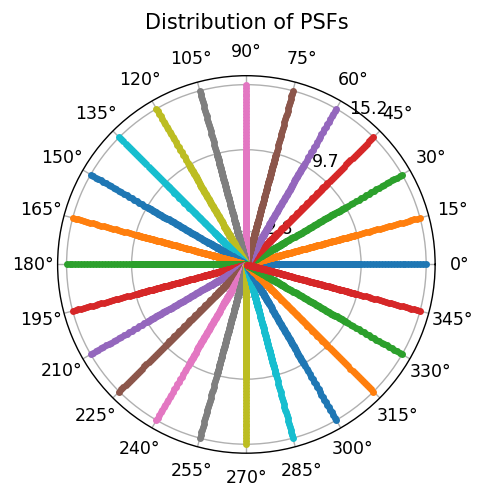

In [17]:
iwa = 2.8
owa = 9.7

sampling1 = 0.05
offsets1 = np.arange(0,iwa+1,sampling1)

sampling2 = 0.1
offsets2 = np.arange(iwa+1,owa,sampling2)

sampling3 = 0.25
offsets3 = np.arange(owa,15+sampling3,sampling3)

r_offsets = np.hstack([offsets1, offsets2, offsets3])
r_offsets_mas = r_offsets*mas_per_lamD
print(r_offsets.shape, r_offsets)

sampling_theta = 15
thetas = np.arange(0,360,sampling_theta)*u.deg
print(thetas.shape, thetas)

psfs_required = len(thetas)*len(r_offsets)
psfs_size_gb = psfs_required*(256**2)*8/1e9
time_required = 17*len(thetas)*len(r_offsets)/3600
print(psfs_required, psfs_size_gb, time_required)

r_offsets_hdu = fits.PrimaryHDU(data=r_offsets)
r_offsets_fpath = data_dir/'psfs'/'hlc_575_psfs_072022_radial_samples.fits'
r_offsets_hdu.writeto(r_offsets_fpath, overwrite=True)

thetas_hdu = fits.PrimaryHDU(data=thetas.value)
thetas_fpath = data_dir/'psfs'/'hlc_575_psfs_072022_theta_samples.fits'
thetas_hdu.writeto(thetas_fpath, overwrite=True)

# Plotting field angles
theta_offsets = []
for r in r_offsets[1:]:
    theta_offsets.append(thetas.to(u.radian).value)
theta_offsets = np.array(theta_offsets)
theta_offsets.shape

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, dpi=125)
ax.plot(theta_offsets, r_offsets[1:], '.')
ax.set_rticks([iwa, owa, max(r_offsets)])  # Less radial ticks
ax.set_thetagrids(thetas.value)
ax.set_rlabel_position(55)  # Move radial labels away from plotted line
ax.grid(True)
ax.set_title('Distribution of PSFs', va='bottom')
plt.show()

In [18]:
nlam = 1
lam0 = 0.575
if nlam==1:
    lam_array = np.array([lam0])
else:
    bandwidth = 0.1
    minlam = lam0 * (1 - bandwidth/2)
    maxlam = lam0 * (1 + bandwidth/2)
    lam_array = np.linspace( minlam, maxlam, nlam )

dm1 = proper.prop_fits_read( roman_phasec_proper.lib_dir + r'/examples/hlc_best_contrast_dm1.fits' )
dm2 = proper.prop_fits_read( roman_phasec_proper.lib_dir + r'/examples/hlc_best_contrast_dm2.fits' )

options = {'cor_type':'hlc', # change coronagraph type to correct band
           'final_sampling_lam0':psf_pixelscale_lamD, 
           'source_x_offset':0,
           'source_y_offset':0,
           'use_fpm':1,
           'use_field_stop':1,
           'use_errors':1,
           'use_lens_errors':1,
           'use_hlc_dm_patterns':0,
           'use_dm1':1, 'dm1_m':dm1, 
           'use_dm2':1, 'dm2_m':dm2,
           'polaxis':polaxis,   
          }

Lambda = 5.7500E-07   Throughput = 1.00
Applying lens
Propagating to secondary
Applying lens
Propagating to POMA FOLD
Propagating to M3
Applying lens
Propagating to M4
Applying lens
Propagating to M5
Applying lens
Propagating to TT FOLD
Propagating to FSM
Propagating to OAP1
Applying lens
Propagating to FOCM
Propagating to OAP2
Applying lens
Propagating to DM1
Propagating to DM2
Propagating to OAP3
Applying lens
Propagating to FOLD_3
Propagating to OAP4
Applying lens
Propagating to PUPIL_MASK
Propagating to OAP5
Applying lens
Propagating to FPM
Propagating to OAP6
Applying lens
Propagating to LYOT STOP
Propagating to OAP7
Applying lens
Propagating to FIELD_STOP
Propagating to OAP8
Applying lens
Propagating to filter
Propagating to IMAGING LENS
Applying lens at IMAGING LENS lens #1
Propagating
Applying lens at IMAGING LENS lens #2
Propagating to IMAGE
Total elapsed time (seconds) =  12.5653


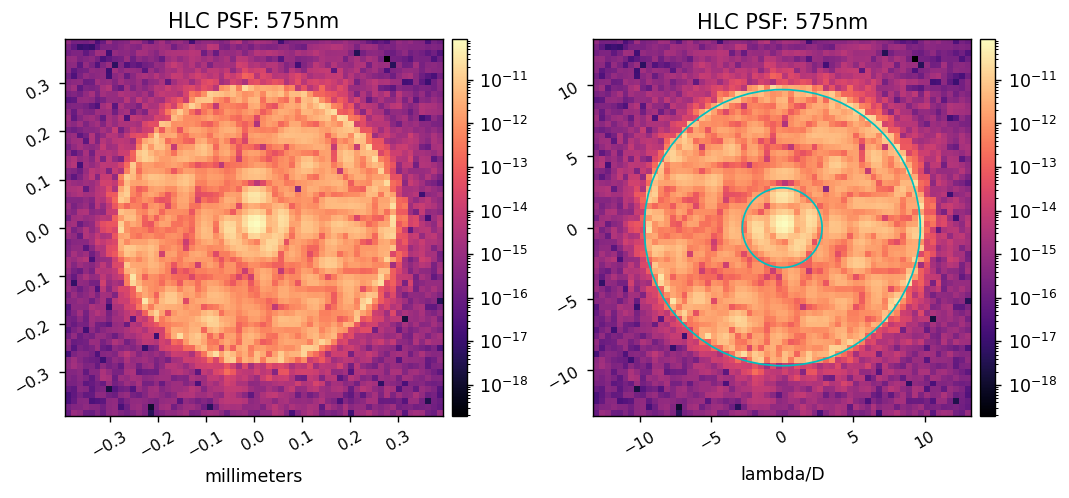

In [19]:
(wfs, pxscls_m) = proper.prop_run_multi('roman_phasec', lam_array, npsf, QUIET=False, PASSVALUE=options)

psfs = np.abs(wfs)**2
psf_bb = np.sum(psfs, axis=0)/nlam
psf_pixelscale_m = pxscls_m[0]*u.m/u.pix

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.myimshow2(psf_bb, psf_bb, 'HLC PSF: 575nm', 'HLC PSF: 575nm',
               lognorm1=True, lognorm2=True, 
               pxscl1=psf_pixelscale_m.to(u.mm/u.pix), pxscl2=psf_pixelscale_lamD, patches2=patches)

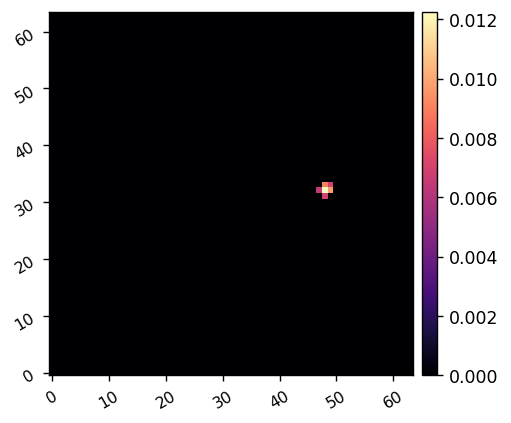

0.051458144788823115

In [12]:
mask = psf_bb > psf_bb.max()/2
psf = psf_bb*mask

misc.myimshow(psf)

psf.sum()


In [4]:
psfs_array = np.zeros( shape=( (len(r_offsets)-1)*len(thetas) + 1, npsf,npsf) )

count = 0
start = time.time()
for i,r in enumerate(r_offsets): 
    opts = []
    for j,th in enumerate(thetas):
        xoff = r*np.cos(th)
        yoff = r*np.sin(th)
        options.update( {'source_x_offset':xoff.value, 'source_y_offset':yoff.value} )
        opts.append(copy.copy(options))
        if r<r_offsets[1]: break
    
    (wfs, pxscls_m) = proper.prop_run_multi('roman_phasec', lam_array, npsf, QUIET=True, PASSVALUE=opts)

    psfs = np.abs(wfs)**2
    psf_pixelscale_m = pxscls_m[0]*u.m/u.pix
    
    if r<r_offsets[1]: psfs_array[0] = psfs[0]
    else: psfs_array[int( (count-1)*len(thetas) + 1 ):int( count*len(thetas) + 1 )] = psfs
    
    print(count, time.time()-start)
    count += 1

0 14.09762978553772
1 31.401215076446533
2 48.13825798034668
3 65.14880061149597
4 81.76213335990906
5 98.28312397003174
6 115.08960747718811
7 131.88640570640564
8 149.11948585510254
9 165.77097272872925
10 182.5370213985443
11 199.16632890701294
12 216.32905077934265
13 232.7878701686859
14 249.70788860321045
15 266.4007034301758
16 283.4959840774536
17 300.47153663635254
18 317.70918703079224
19 334.44209933280945
20 351.42847776412964
21 368.37057733535767
22 385.18731021881104
23 402.3697278499603
24 419.2017776966095
25 436.1309733390808
26 453.03434896469116
27 470.19953298568726
28 487.4262716770172
29 504.24685406684875
30 521.3268306255341
31 538.2781760692596
32 555.1840405464172
33 572.0323138237
34 589.1150758266449
35 606.1449248790741
36 622.8392188549042
37 640.1126606464386
38 656.668267250061
39 673.7628536224365
40 690.9068620204926
41 708.1455202102661
42 725.7736911773682
43 742.7587540149689
44 759.9532642364502
45 777.2716109752655
46 794.3144912719727
47 811.399

In [ ]:
for i in range(psfs_array.shape[0]):
    clear_output(wait=True)
    misc.myimshow(psfs_array[i], 'PSF {:d}'.format(i), lognorm=True)
    time.sleep(0.1)

In [9]:
hdr = fits.Header()
hdr['PXSCLAMD'] = psf_pixelscale_lamD
hdr.comments['PXSCLAMD'] = 'pixel scale in lam0/D per pixel'
hdr['PXSCLMAS'] = psf_pixelscale_mas.value
hdr.comments['PXSCLMAS'] = 'pixel scale in mas per pixel'
hdr['PIXELSCL'] = psf_pixelscale_m.value
hdr.comments['PIXELSCL'] = 'pixel scale in meters per pixel'
hdr['CWAVELEN'] = wavelength_c.value
hdr.comments['CWAVELEN'] = 'central wavelength in meters'
hdr['BANDPASS'] = 0
hdr.comments['BANDPASS'] = 'bandpass as fraction of CWAVELEN'
hdr['POLAXIS'] = polaxis
hdr.comments['POLAXIS'] = 'polaxis: defined by roman_phasec_proper'

psfs_hdu = fits.PrimaryHDU(data=psfs_array, header=hdr)

psfs_fpath = data_dir/'psfs'/'hlc_band1_psfs_072022.fits'
psfs_hdu.writeto(psfs_fpath, overwrite=True)